## Transfer Learning on Cats-Dogs Classification - Fine Tune

#### Finetune MobileNet-V2 top layers and classification layers to classify cats vs. dogs.
Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### SDSC Summer Institute
Mai H. Nguyen, UC San Diego

-----

### Setup

In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [2]:
print (tf.__version__)
!python --version

2.5.0
Python 3.6.9


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi

Mon Aug  1 19:23:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   36C    P0    42W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Set logging level
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
# Set random generator seed
seed = 1234

# Disable hash randomization by specifying the value 0.
os.environ['PYTHONHASHSEED'] = '0'

# Set numpy random generator
np.random.seed(seed)

# Set python built-in random generator
random.seed(seed)

# Set tf global random seed
tf.random.set_seed(seed)

# Set tensorflow graph-level random seed
tf.compat.v1.random.set_random_seed(seed)

# Potential randomness from CUDNN
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image location and dimensions

In [7]:
import os 

USER = os.environ['USER']
SLURM_JOBID = os.environ['SLURM_JOBID']

data_path = '/scratch/' + USER + '/job_' + SLURM_JOBID + '/catsVsDogs'
print (data_path)

# Location of images
train_data_dir = data_path + '/train'
val_data_dir   = data_path + '/val'
test_data_dir  = data_path + '/test'

print ('Train path:' + train_data_dir)
print ('Validation path:' + val_data_dir)
print ('Test path:' + test_data_dir)

/scratch/mhnguyen/job_14832705/catsVsDogs
Train path:/scratch/mhnguyen/job_14832705/catsVsDogs/train
Validation path:/scratch/mhnguyen/job_14832705/catsVsDogs/val
Test path:/scratch/mhnguyen/job_14832705/catsVsDogs/test


In [8]:
# Image dimensions
img_width, img_height = 224, 224 
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

### Prepare data

In [9]:
# Batch size
BATCH_SIZE = 16

# Data setup
rescale = tf.keras.applications.mobilenet_v2.preprocess_input
train_datagen      = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = rescale)
validation_datagen = ImageDataGenerator(preprocessing_function = rescale)
test_datagen       = ImageDataGenerator(preprocessing_function = rescale)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='binary', 
                                                    shuffle = True,
                                                    seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = validation_datagen.flow_from_directory(val_data_dir,
                                                              target_size=IMG_SIZE,
                                                              batch_size = BATCH_SIZE,
                                                              class_mode='binary',
                                                              shuffle = False, 
                                                              seed = seed)
# Set up generator to generate batched of test data for model
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode='binary',
                                                  shuffle = False,
                                                  seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load model from feature extraction
Load model saved from feature extraction.  Weights in last blocks and top model will be adjusted.  All other weights are frozen.

In [10]:
model = tf.keras.models.load_model('models/features_model')

In [11]:
# Uncomment to list layers in model
# print("Number of layers in the base model: ", len(model.layers[1].layers))
# list(enumerate(model.layers[1].layers))

In [12]:
## Freeze all weights of model up to Block 14
model.trainable = True
fine_tune_start = 116
for layer in model.layers[1].layers[:fine_tune_start]:
    layer.trainable = False
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,682,625
Non-trainable params: 576,640
_________________________________________________________________


### Fine tune model

In [13]:
EPOCHS = 20

# Compile model with very slow learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss= losses.BinaryCrossentropy(),metrics=['accuracy'])

# Perform early stopping to avoid overfitting and ModelCheckpoint to save the best model
checkpoint_path = 'tmp/checkpoint'
callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min'),
             ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', mode = 'min', 
                             save_best_only = True, save_weights_only=True)]

In [14]:
%%time

train_history = model.fit(train_generator,epochs=EPOCHS, 
                          validation_data=validation_generator, 
                          callbacks=callbacks)

Epoch 1/20
125/125 [==============================] - 23s 150ms/step - loss: 0.2682 - accuracy: 0.8955 - val_loss: 0.0836 - val_accuracy: 0.9675
Epoch 2/20
125/125 [==============================] - 18s 145ms/step - loss: 0.1368 - accuracy: 0.9560 - val_loss: 0.0680 - val_accuracy: 0.9800
Epoch 3/20
125/125 [==============================] - 18s 145ms/step - loss: 0.1050 - accuracy: 0.9645 - val_loss: 0.0557 - val_accuracy: 0.9850
Epoch 4/20
125/125 [==============================] - 18s 145ms/step - loss: 0.1123 - accuracy: 0.9595 - val_loss: 0.0406 - val_accuracy: 0.9900
Epoch 5/20
125/125 [==============================] - 18s 145ms/step - loss: 0.0767 - accuracy: 0.9795 - val_loss: 0.0388 - val_accuracy: 0.9850
Epoch 6/20
125/125 [==============================] - 18s 145ms/step - loss: 0.0732 - accuracy: 0.9770 - val_loss: 0.0376 - val_accuracy: 0.9850
Epoch 7/20
125/125 [==============================] - 18s 145ms/step - loss: 0.0640 - accuracy: 0.9760 - val_loss: 0.0387 - val_ac

In [15]:
# Load the best model that was saved using ModelCheckpoint
model.load_weights(checkpoint_path)

In [16]:
# Save weights from finetuning
model.save("models/finetune_model")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


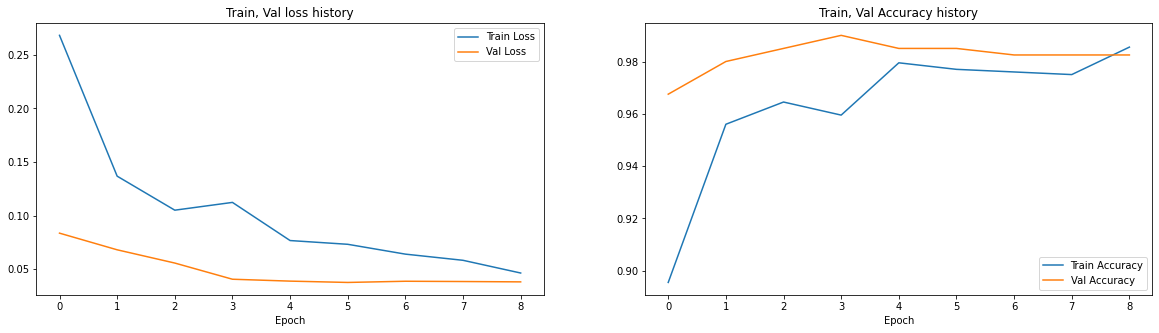

In [17]:
# Plot train and validation loss
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

# Plot train and validation accuracy
axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluate model

In [18]:
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 17s 137ms/step - loss: 0.0190 - accuracy: 0.9970
Train data accuracy: 0.996999979019165
25/25 [==============================] - 1s 38ms/step - loss: 0.0355 - accuracy: 0.9875
Test data accuracy: 0.987500011920929


In [19]:
# Get predicted value and the ground truth value of test data
pred = (model.predict(test_generator) > 0.5).astype("int32")
true = test_generator.classes

In [20]:
# Get evaluation metrics for test data
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs'], digits=4))

              precision    recall  f1-score   support

        cats     0.9851    0.9900    0.9875       200
        dogs     0.9899    0.9850    0.9875       200

    accuracy                         0.9875       400
   macro avg     0.9875    0.9875    0.9875       400
weighted avg     0.9875    0.9875    0.9875       400



### Perform inference on test images

In [21]:
def image_loader(img_file):
    """load individual images"""
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    # img = img_to_array(img) / 255
    img = (img_to_array(img)/127.5)-1.0
    img = np.expand_dims(img, axis = 0) #model input is (1,150,150,3)
    return img

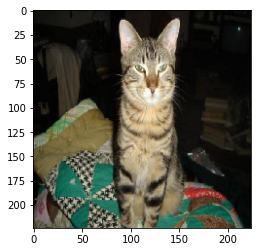

[[0.00255]]


In [22]:
test_image = data_path + '/test/cats/cat.1070.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

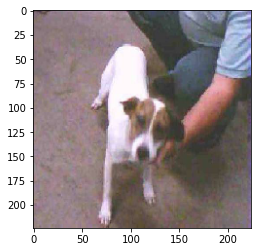

[[0.99982]]


In [23]:
test_image = data_path + '/test/dogs/dog.1233.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

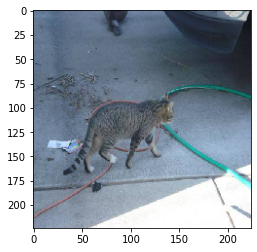

[[0.3517]]


In [24]:
test_image = data_path + '/test/cats/cat.1080.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

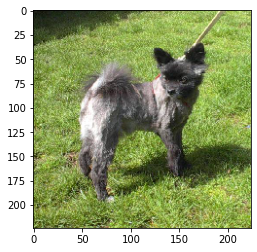

[[0.59683]]


In [25]:
test_image = data_path + '/test/dogs/dog.1132.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

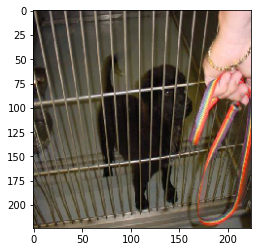

[[0.28983]]


In [26]:
test_image = data_path + '/test/dogs/dog.1311.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

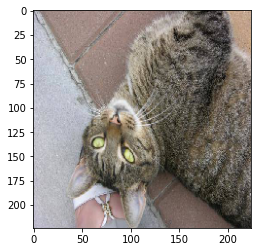

[[0.04294]]


In [27]:
test_image = data_path + '/test/cats/cat.1338.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

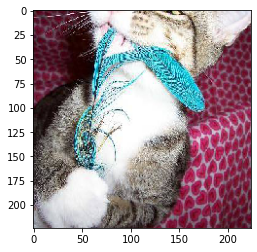

[[0.10093527]]


In [28]:
test_image = data_path + '/test/cats/cat.1342.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(img_y_pred)

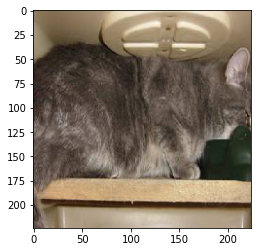

[[0.00012]]


In [29]:
test_image = data_path + '/test/cats/cat.1180.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

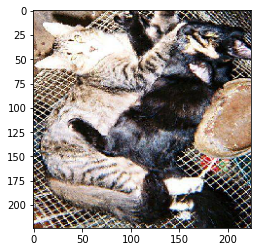

[[0.6627]]


In [30]:
test_image = data_path + '/test/cats/cat.1048.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

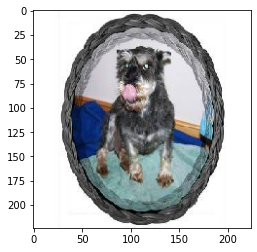

[[0.99158]]


In [31]:
test_image = data_path + '/test/dogs/dog.1342.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))